<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/5_demographic_space_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/5_demographic_space_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 5: Demographic Space Mapping via PCA

This notebook applies PCA to the 120 extracted demographic vectors to discover a low-dimensional
"Demographic Space" — analogous to the "Assistant Axis" from Lu et al. (2026).

**Goals:**
1. Identify interpretable principal components (PC1, PC2, PC3)
2. Visualize the demographic landscape in 2D/3D
3. Compare PCA structure with GSS phi-coefficient correlations
4. Analyze how demographic structure varies across layers

**Input:** `vectors/gss_demographic_vectors_layer{N}.pt` (120 vectors × 4096 dims per layer)

**No GPU required** — PCA on a 120 × 4096 matrix is CPU-only.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.cm import get_cmap
import os
import json

In [2]:
# Mount Google Drive (Colab) or use local path
try:
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/MyDrive/belief_and_llms_v0"
except ImportError:
    BASE_DIR = "."

VECTOR_DIR = os.path.join(BASE_DIR, "vectors")
DATA_DIR = os.path.join(BASE_DIR, "data")

# Reference layer: 13 (peak delta magnitude from Phase 3 analysis)
REF_LAYER = 13

print(f"Base directory: {BASE_DIR}")
print(f"Vector directory: {VECTOR_DIR}")
print(f"Reference layer: {REF_LAYER}")

Mounted at /content/drive
Base directory: /content/drive/MyDrive/belief_and_llms_v0
Vector directory: /content/drive/MyDrive/belief_and_llms_v0/vectors
Reference layer: 13


## Load Vectors

In [3]:
# Load vectors for the reference layer
vectors = torch.load(
    os.path.join(VECTOR_DIR, f"gss_demographic_vectors_layer{REF_LAYER}.pt"),
    map_location="cpu",
    weights_only=True,
)

print(f"Loaded {len(vectors)} demographic vectors from layer {REF_LAYER}")
print(f"Vector dimension: {vectors[list(vectors.keys())[0]]['vector'].shape[0]}")
print(f"\nCategories: {sorted(set(k.split('_')[0] for k in vectors.keys()))}")

Loaded 120 demographic vectors from layer 13
Vector dimension: 4096

Categories: ['Age', 'Children', 'Class', 'Degree', 'FamilyIncome', 'Generation', 'God', 'Happy', 'Health', 'ImmigGen', 'Industry', 'Life', 'Marital', 'Occupation', 'OwnGun', 'PartyID', 'PolViews', 'Race', 'Region', 'Region16', 'Religion', 'SatFin', 'SatJob', 'Sex', 'Urbanity']


## Build Vector Matrix

We use **unnormalized vectors** (direction × magnitude) for PCA, since magnitude encodes how strongly the model differentiates each demographic. This follows the approach in "The Assistant Axis" (Lu et al., 2026).

In [4]:
labels = sorted(vectors.keys())
categories = [label.split('_')[0] for label in labels]

# Reconstruct raw (unnormalized) vectors: direction * magnitude
raw_matrix = []
for label in labels:
    v = vectors[label]['vector'] * vectors[label]['magnitude']
    raw_matrix.append(v.numpy())
X = np.array(raw_matrix)  # Shape: (120, 4096)

# Also build normalized-only matrix for comparison
norm_matrix = np.array([vectors[label]['vector'].numpy() for label in labels])

print(f"Unnormalized matrix shape: {X.shape}")
print(f"Normalized matrix shape: {norm_matrix.shape}")

# Show magnitude distribution
magnitudes = np.array([vectors[label]['magnitude'] for label in labels])
print(f"\nMagnitude stats: min={magnitudes.min():.4f}, max={magnitudes.max():.4f}, "
      f"mean={magnitudes.mean():.4f}, std={magnitudes.std():.4f}")

Unnormalized matrix shape: (120, 4096)
Normalized matrix shape: (120, 4096)

Magnitude stats: min=0.5386, max=2.6973, mean=1.4133, std=0.4497


## PCA: Explained Variance

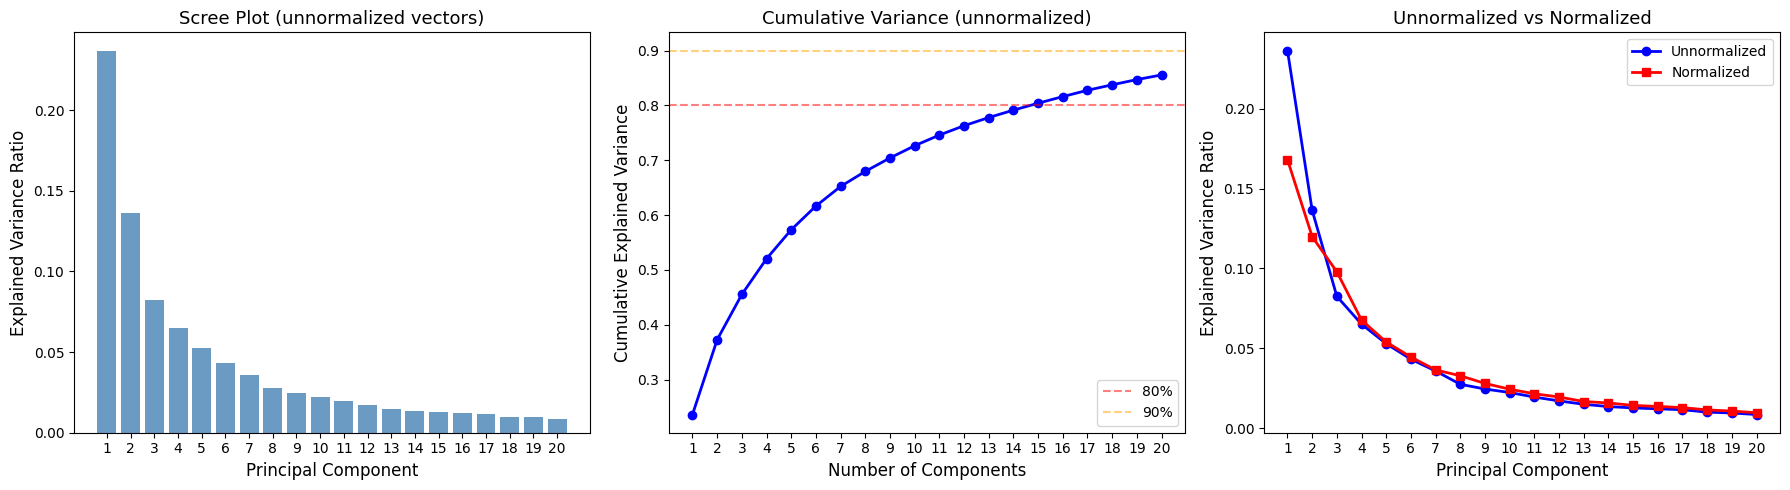


Top 10 PCs explained variance (unnormalized):
  PC1: 0.2365 (cumulative: 0.2365)
  PC2: 0.1364 (cumulative: 0.3729)
  PC3: 0.0825 (cumulative: 0.4554)
  PC4: 0.0651 (cumulative: 0.5205)
  PC5: 0.0528 (cumulative: 0.5734)
  PC6: 0.0432 (cumulative: 0.6165)
  PC7: 0.0358 (cumulative: 0.6523)
  PC8: 0.0274 (cumulative: 0.6797)
  PC9: 0.0245 (cumulative: 0.7042)
  PC10: 0.0223 (cumulative: 0.7265)


In [5]:
n_components = min(30, len(labels))
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Also run PCA on normalized vectors for comparison
pca_norm = PCA(n_components=n_components)
X_pca_norm = pca_norm.fit_transform(norm_matrix)

# Scree plot and cumulative variance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scree plot (unnormalized)
axes[0].bar(range(1, 21), pca.explained_variance_ratio_[:20], color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot (unnormalized vectors)', fontsize=13)
axes[0].set_xticks(range(1, 21))

# Cumulative (unnormalized)
cum_var = np.cumsum(pca.explained_variance_ratio_[:20])
axes[1].plot(range(1, 21), cum_var, 'bo-', linewidth=2, markersize=6)
axes[1].axhline(0.8, color='red', linestyle='--', alpha=0.5, label='80%')
axes[1].axhline(0.9, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance (unnormalized)', fontsize=13)
axes[1].legend()
axes[1].set_xticks(range(1, 21))

# Comparison: unnormalized vs normalized
axes[2].plot(range(1, 21), pca.explained_variance_ratio_[:20], 'bo-', label='Unnormalized', linewidth=2)
axes[2].plot(range(1, 21), pca_norm.explained_variance_ratio_[:20], 'rs-', label='Normalized', linewidth=2)
axes[2].set_xlabel('Principal Component', fontsize=12)
axes[2].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[2].set_title('Unnormalized vs Normalized', fontsize=13)
axes[2].legend()
axes[2].set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

print(f"\nTop 10 PCs explained variance (unnormalized):")
for i in range(10):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} "
          f"(cumulative: {sum(pca.explained_variance_ratio_[:i+1]):.4f})")

## PC1 vs PC2: Demographic Landscape

/tmp/ipython-input-3445824172.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = [get_cmap('tab20')(i / 20) for i in range(20)]
/tmp/ipython-input-3445824172.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20b = [get_cmap('tab20b')(i / 20) for i in range(20)]


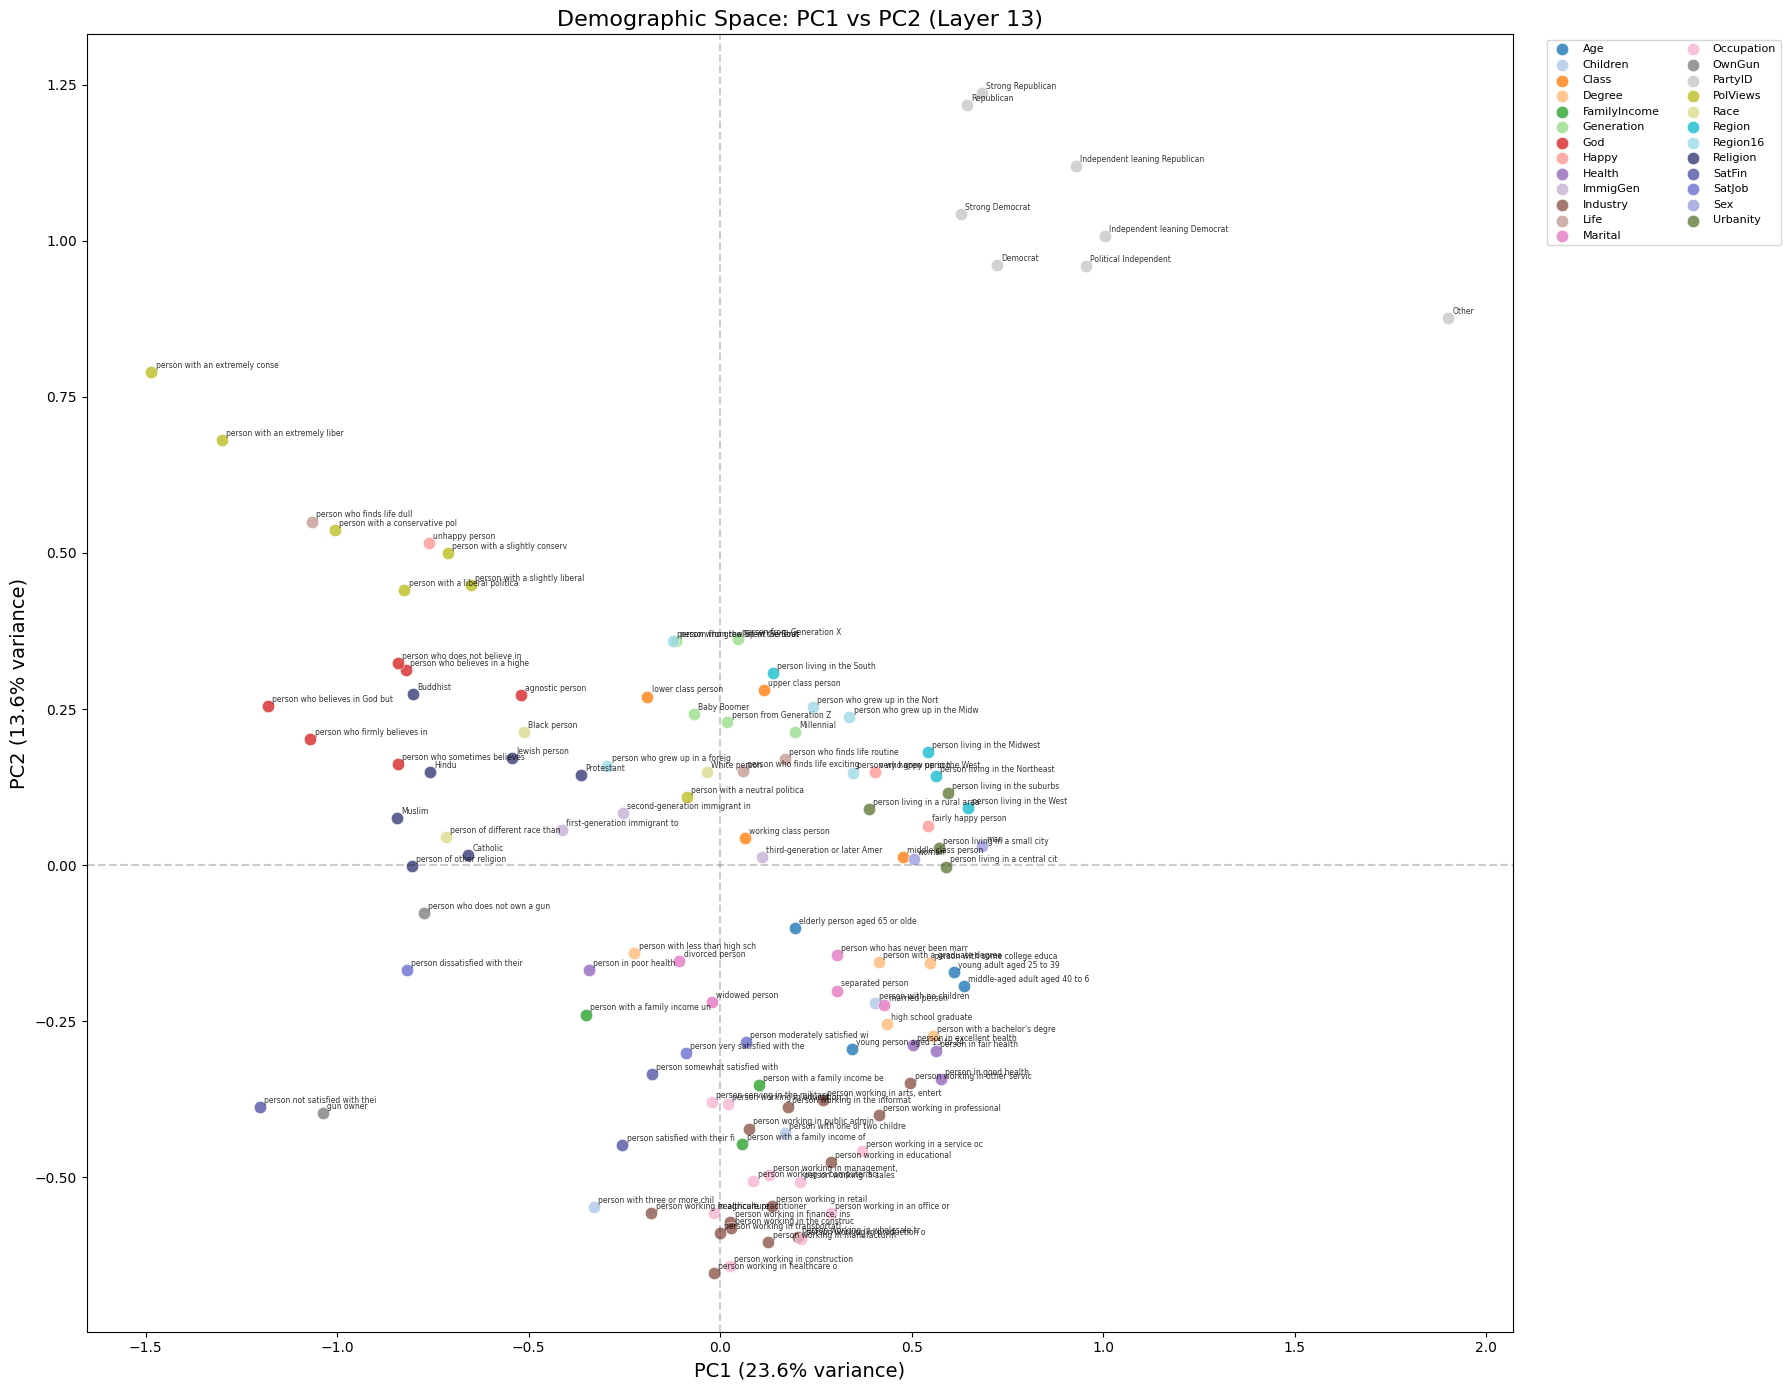

In [6]:
# Build PCA dataframe
df_pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'label': labels,
    'category': categories,
    'short_label': [label.split('_', 1)[1][:30] for label in labels],
    'magnitude': magnitudes,
})

# Color palette for ~25 categories
unique_cats = sorted(df_pca['category'].unique())
n_cats = len(unique_cats)
tab20 = [get_cmap('tab20')(i / 20) for i in range(20)]
tab20b = [get_cmap('tab20b')(i / 20) for i in range(20)]
all_colors = tab20 + tab20b[:n_cats - 20] if n_cats > 20 else tab20[:n_cats]
cat_to_color = {cat: all_colors[i] for i, cat in enumerate(unique_cats)}

# PC1 vs PC2 scatter
fig, ax = plt.subplots(figsize=(18, 14))

for cat in unique_cats:
    mask = df_pca['category'] == cat
    ax.scatter(
        df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
        label=cat, color=cat_to_color[cat], s=80, alpha=0.8,
        edgecolors='white', linewidth=0.5,
    )

# Annotate all points
for _, row in df_pca.iterrows():
    ax.annotate(
        row['short_label'], (row['PC1'], row['PC2']),
        fontsize=5.5, alpha=0.8,
        xytext=(3, 3), textcoords='offset points',
    )

ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
ax.set_title(f'Demographic Space: PC1 vs PC2 (Layer {REF_LAYER})', fontsize=16)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

## PC1 vs PC3 and PC2 vs PC3

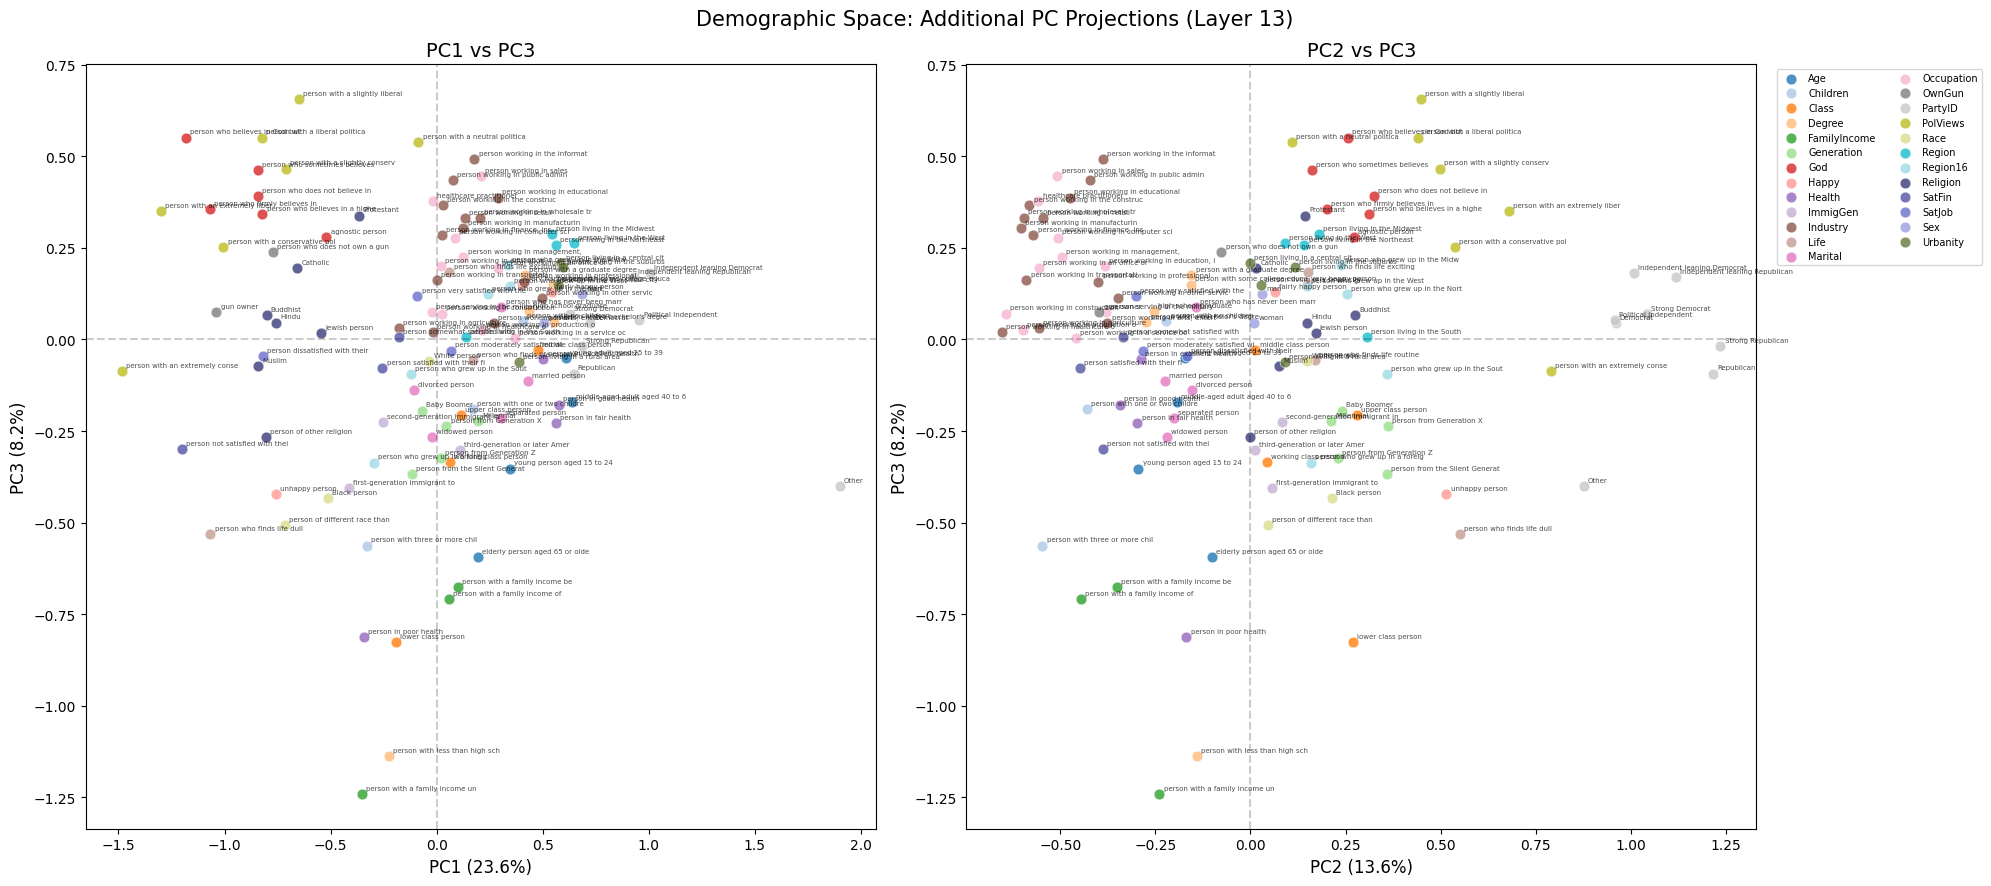

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

for ax, (pcx, pcy), title in zip(
    axes,
    [('PC1', 'PC3'), ('PC2', 'PC3')],
    ['PC1 vs PC3', 'PC2 vs PC3'],
):
    for cat in unique_cats:
        mask = df_pca['category'] == cat
        ax.scatter(
            df_pca.loc[mask, pcx], df_pca.loc[mask, pcy],
            label=cat, color=cat_to_color[cat], s=60, alpha=0.8,
            edgecolors='white', linewidth=0.5,
        )

    for _, row in df_pca.iterrows():
        ax.annotate(
            row['short_label'], (row[pcx], row[pcy]),
            fontsize=5, alpha=0.7,
            xytext=(3, 3), textcoords='offset points',
        )

    pc_x_idx = int(pcx[2]) - 1
    pc_y_idx = int(pcy[2]) - 1
    ax.axhline(0, color='black', linestyle='--', alpha=0.2)
    ax.axvline(0, color='black', linestyle='--', alpha=0.2)
    ax.set_xlabel(f'{pcx} ({pca.explained_variance_ratio_[pc_x_idx]:.1%})', fontsize=12)
    ax.set_ylabel(f'{pcy} ({pca.explained_variance_ratio_[pc_y_idx]:.1%})', fontsize=12)
    ax.set_title(title, fontsize=14)

axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=7, ncol=2)
plt.suptitle(f'Demographic Space: Additional PC Projections (Layer {REF_LAYER})', fontsize=15)
plt.tight_layout()
plt.show()

## PC Interpretation: Top/Bottom Demographics on Each PC

For each PC, the "poles" (highest/lowest projections) reveal what that axis represents.

In [8]:
for pc_idx in range(5):
    pc_name = f'PC{pc_idx + 1}'
    projections = X_pca[:, pc_idx]
    sorted_idx = np.argsort(projections)

    print(f"\n{'=' * 70}")
    print(f"{pc_name} — Explained Variance: {pca.explained_variance_ratio_[pc_idx]:.2%}")
    print(f"{'=' * 70}")

    print(f"\n  POSITIVE pole (top 10):")
    for i in sorted_idx[-10:][::-1]:
        print(f"    {projections[i]:+8.4f}  [{categories[i]:12s}]  {labels[i]}")

    print(f"\n  NEGATIVE pole (bottom 10):")
    for i in sorted_idx[:10]:
        print(f"    {projections[i]:+8.4f}  [{categories[i]:12s}]  {labels[i]}")


PC1 — Explained Variance: 23.65%

  POSITIVE pole (top 10):
     +1.9005  [PartyID     ]  PartyID_Other
     +1.0041  [PartyID     ]  PartyID_Independent leaning Democrat
     +0.9560  [PartyID     ]  PartyID_Political Independent
     +0.9296  [PartyID     ]  PartyID_Independent leaning Republican
     +0.7241  [PartyID     ]  PartyID_Democrat
     +0.6843  [PartyID     ]  PartyID_Strong Republican
     +0.6842  [Sex         ]  Sex_man
     +0.6461  [Region      ]  Region_person living in the West
     +0.6456  [PartyID     ]  PartyID_Republican
     +0.6372  [Age         ]  Age_middle-aged adult aged 40 to 64

  NEGATIVE pole (bottom 10):
     -1.4853  [PolViews    ]  PolViews_person with an extremely conservative political view
     -1.3017  [PolViews    ]  PolViews_person with an extremely liberal political view
     -1.2026  [SatFin      ]  SatFin_person not satisfied with their financial situation
     -1.1806  [God         ]  God_person who believes in God but with some doubts


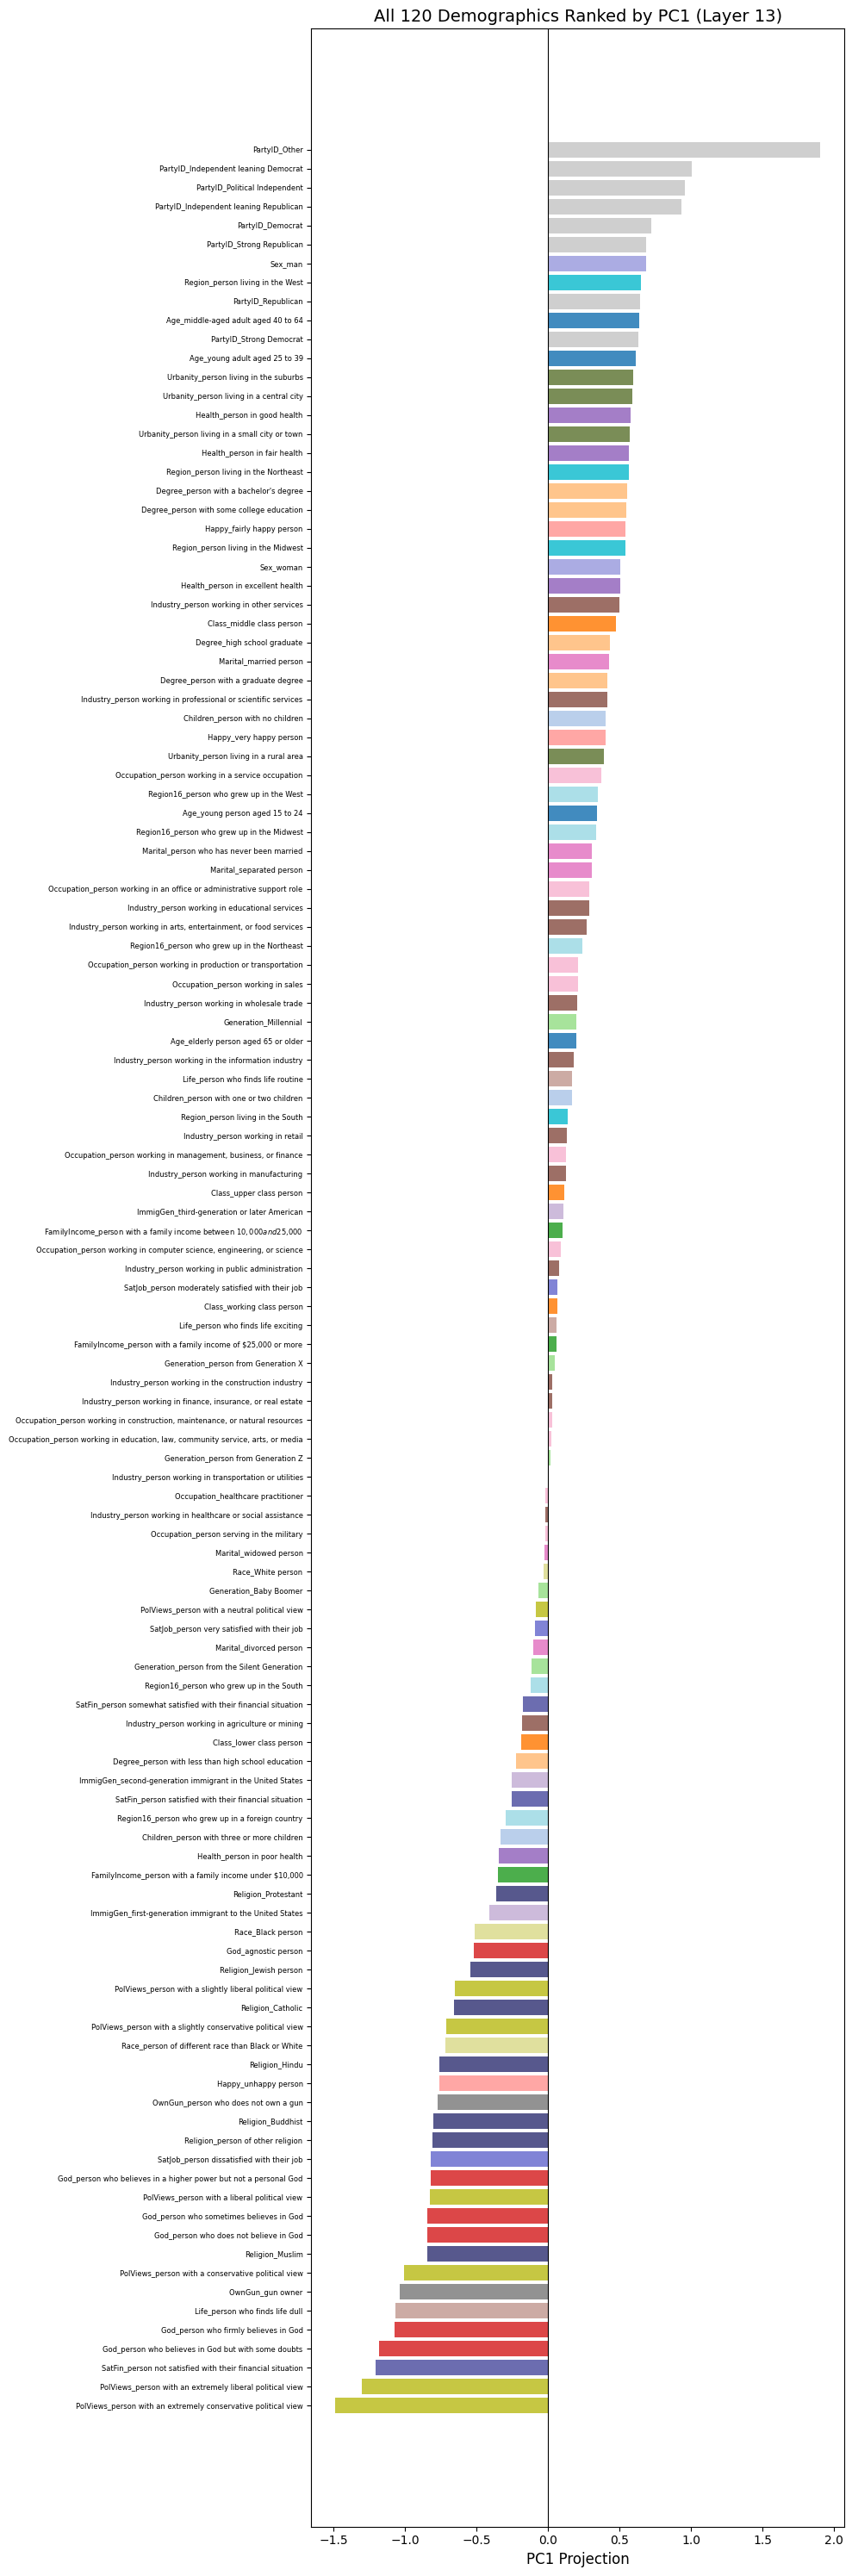

In [9]:
# Horizontal bar chart of PC1 projections for all 120 demographics
sorted_idx = np.argsort(X_pca[:, 0])

fig, ax = plt.subplots(figsize=(10, 30))
y_pos = range(len(sorted_idx))
bar_colors = [cat_to_color[categories[i]] for i in sorted_idx]

ax.barh(y_pos, X_pca[sorted_idx, 0], color=bar_colors, height=0.8, alpha=0.85)
ax.set_yticks(y_pos)
ax.set_yticklabels([labels[i] for i in sorted_idx], fontsize=6)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('PC1 Projection', fontsize=12)
ax.set_title(f'All 120 Demographics Ranked by PC1 (Layer {REF_LAYER})', fontsize=14)

plt.tight_layout()
plt.show()

## Hypothesis Testing: What Do the PCs Represent?

Based on the poles above, we test specific hypotheses:

**PC1 hypothesis — Liberal-Conservative axis:**
- Positive pole: Strong Republican, Conservative, Gun Owner, Believes in God firmly
- Negative pole: Strong Democrat, Liberal, Non-believer, No gun

**PC2 hypothesis — Socioeconomic/Education axis:**
- One pole: Graduate degree, Upper class, High income, Professional occupations
- Other pole: Less than high school, Lower class, Low income, Service/production jobs

**PC3 hypothesis — Age/Generation or Urban/Rural axis:**
- Needs to be determined from the data above

In [10]:
# Test PC1 as Liberal-Conservative: compute average PC1 for politically-relevant groups
political_groups = {
    'Liberal cluster': [
        'PartyID_Strong Democrat',
        'PolViews_person with a liberal political view',
        'PolViews_person with an extremely liberal political view',
    ],
    'Conservative cluster': [
        'PartyID_Strong Republican',
        'PolViews_person with a conservative political view',
        'PolViews_person with an extremely conservative political view',
    ],
}

print("PC1 projections for politically-relevant groups:")
print("=" * 60)
for group_name, group_labels in political_groups.items():
    print(f"\n{group_name}:")
    pc1_values = []
    for lab in group_labels:
        if lab in labels:
            idx = labels.index(lab)
            val = X_pca[idx, 0]
            pc1_values.append(val)
            print(f"  {val:+8.4f}  {lab}")
    if pc1_values:
        print(f"  {'Mean':>8s}: {np.mean(pc1_values):+.4f}")

# Also check culture war demographics
print("\nCulture war demographics on PC1:")
print("=" * 60)
culture_labels = [
    'OwnGun_gun owner', 'OwnGun_person who does not own a gun',
    'God_person who firmly believes in God', 'God_person who does not believe in God',
    'Urbanity_person living in a rural area', 'Urbanity_person living in a central city',
]
for lab in culture_labels:
    if lab in labels:
        idx = labels.index(lab)
        print(f"  {X_pca[idx, 0]:+8.4f}  {lab}")

PC1 projections for politically-relevant groups:

Liberal cluster:
   +0.6296  PartyID_Strong Democrat
   -0.8245  PolViews_person with a liberal political view
   -1.3017  PolViews_person with an extremely liberal political view
      Mean: -0.4989

Conservative cluster:
   +0.6843  PartyID_Strong Republican
   -1.0050  PolViews_person with a conservative political view
   -1.4853  PolViews_person with an extremely conservative political view
      Mean: -0.6020

Culture war demographics on PC1:
   -1.0378  OwnGun_gun owner
   -0.7731  OwnGun_person who does not own a gun
   -1.0700  God_person who firmly believes in God
   -0.8423  God_person who does not believe in God
   +0.3881  Urbanity_person living in a rural area
   +0.5885  Urbanity_person living in a central city


## Cosine Similarity Heatmap

120 × 120 cosine similarity matrix between all demographic vectors, ordered by PC1 projection to reveal cluster structure.

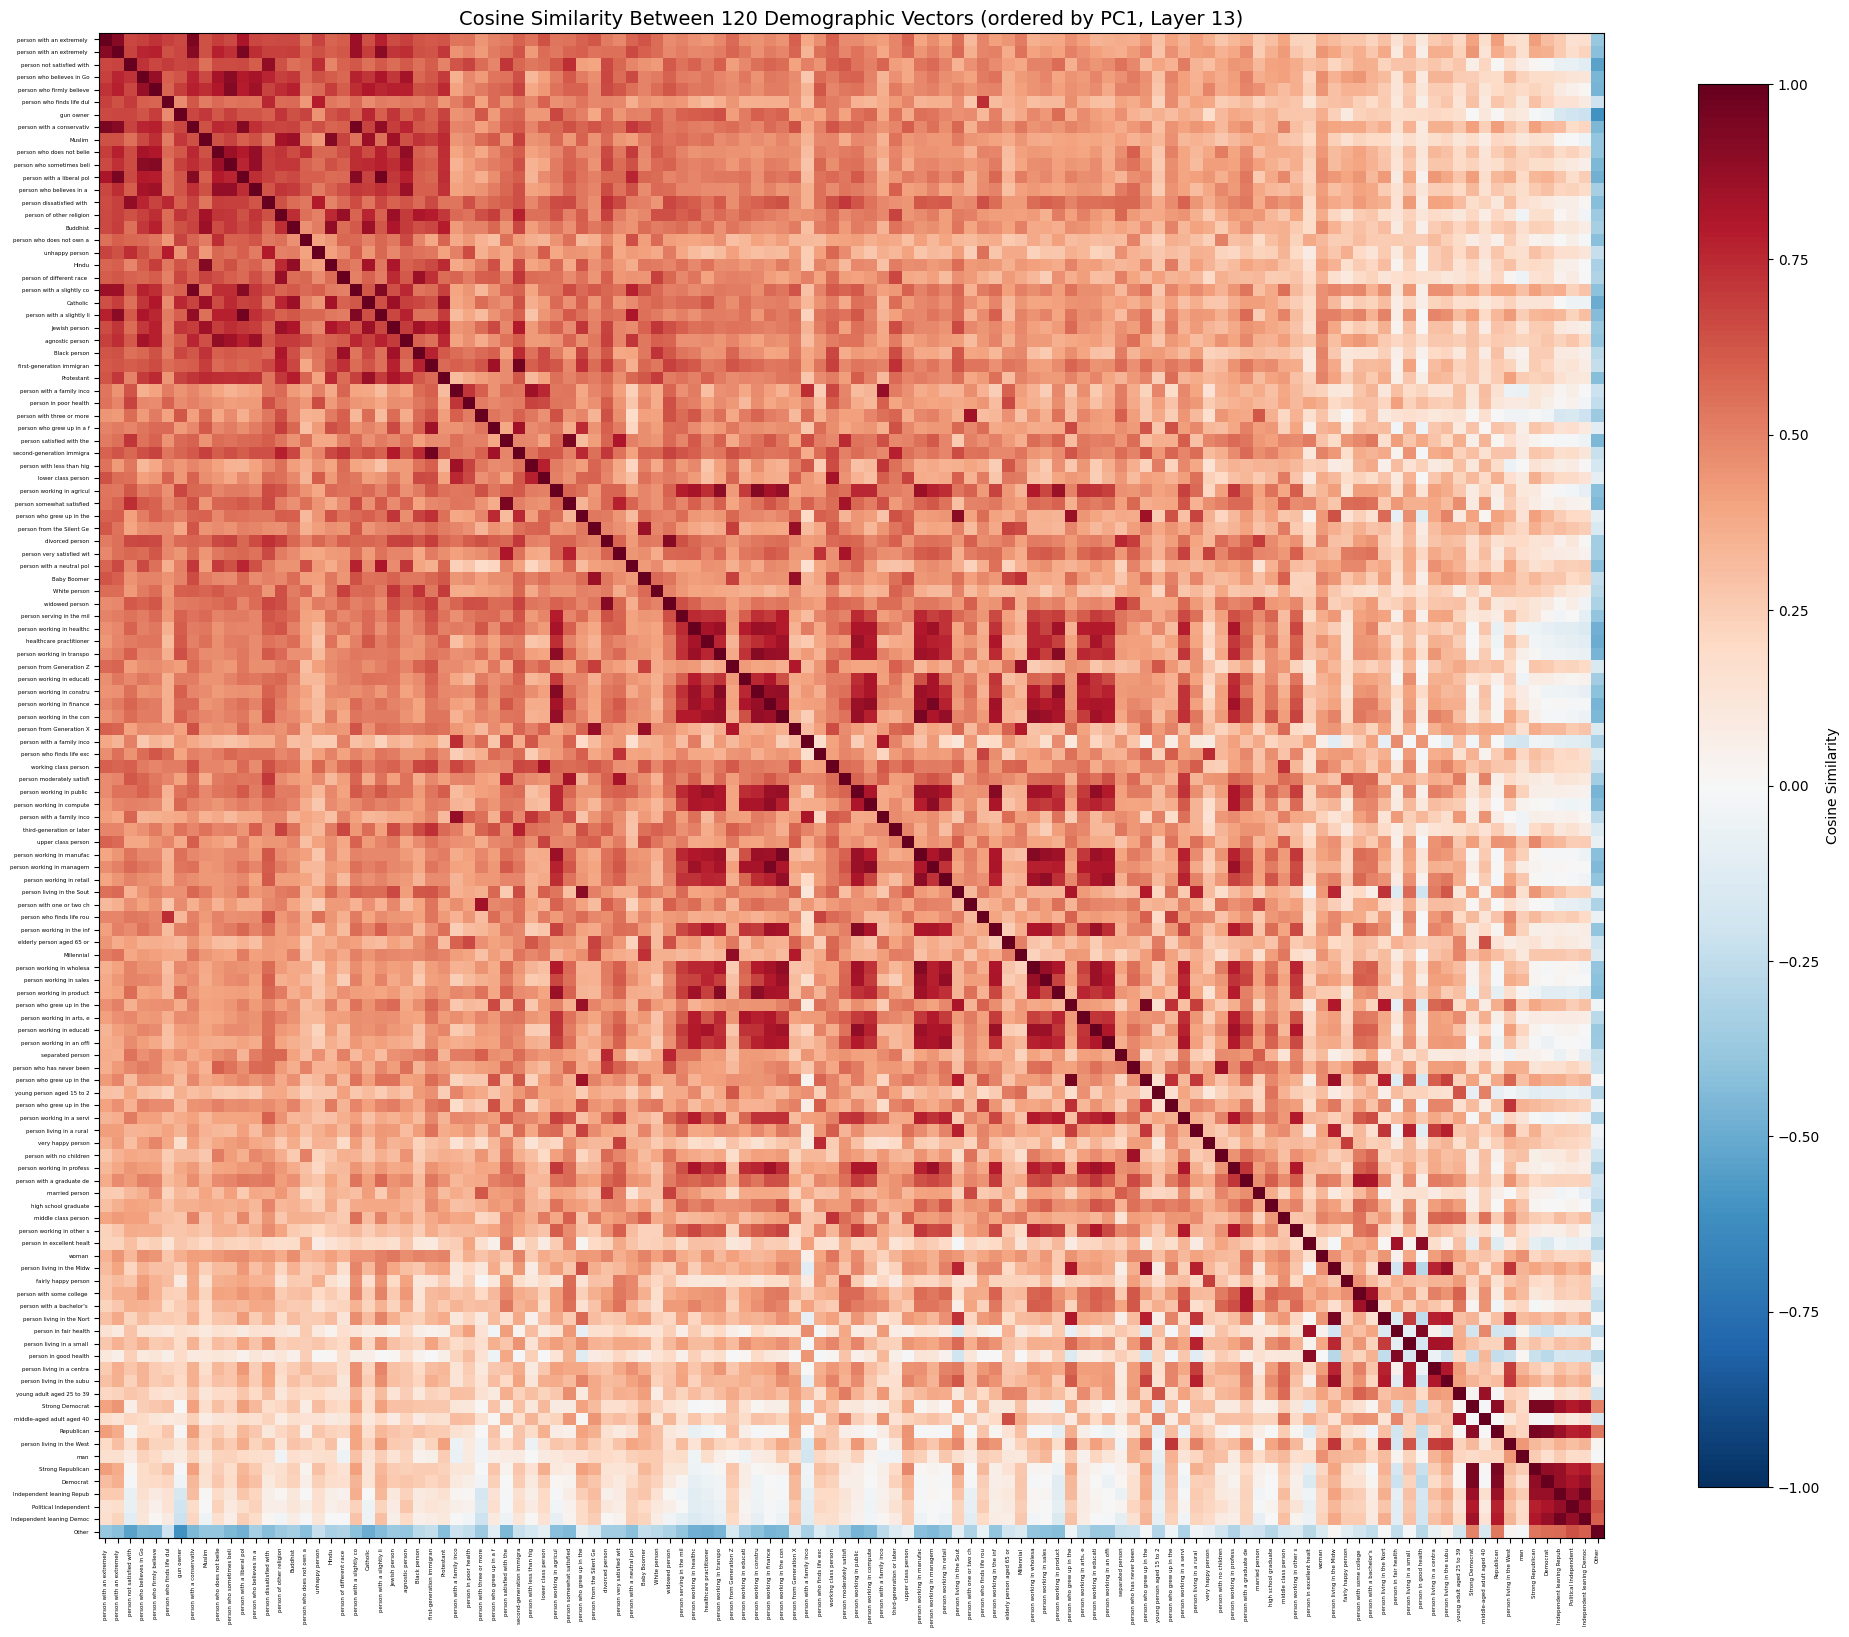


Similarity stats: min=-0.6065, max (off-diag)=1.0000, mean=0.3900


In [11]:
# Compute cosine similarity in full 4096-dim space
cos_sim = cosine_similarity(X)

# Reorder by PC1 projection
order = np.argsort(X_pca[:, 0])
cos_sim_ordered = cos_sim[order][:, order]
labels_ordered = [labels[i] for i in order]
short_labels_ordered = [lab.split('_', 1)[1][:25] for lab in labels_ordered]

fig, ax = plt.subplots(figsize=(20, 18))
im = ax.imshow(cos_sim_ordered, cmap='RdBu_r', vmin=-1, vmax=1, aspect='equal')
ax.set_xticks(range(len(labels_ordered)))
ax.set_yticks(range(len(labels_ordered)))
ax.set_xticklabels(short_labels_ordered, rotation=90, fontsize=4)
ax.set_yticklabels(short_labels_ordered, fontsize=4)
ax.set_title(f'Cosine Similarity Between 120 Demographic Vectors (ordered by PC1, Layer {REF_LAYER})',
             fontsize=14)
plt.colorbar(im, ax=ax, shrink=0.8, label='Cosine Similarity')

plt.tight_layout()
plt.show()

print(f"\nSimilarity stats: min={cos_sim.min():.4f}, max (off-diag)={np.fill_diagonal(cos_sim.copy(), 0) or cos_sim.max():.4f}, mean={cos_sim[np.triu_indices_from(cos_sim, k=1)].mean():.4f}")

## Compare PCA Structure with GSS Phi-Coefficient Correlations

Do demographics that are close in the model's vector space also have high phi-coefficient correlation in real GSS survey data?

In [12]:
# Mapping from GSS correlation pair names to extraction dataset labels
# The correlation CSV uses GSS-internal names; extraction datasets use descriptive labels
GSS_TO_VECTOR = {
    # Race
    'race_Black': 'Race_Black person',
    'race_White': 'Race_White person',
    'race_Other': 'Race_person of different race than Black or White',
    # PartyID
    'partyid_Strong democrat': 'PartyID_Strong Democrat',
    'partyid_Strong republican': 'PartyID_Strong Republican',
    'partyid_Not very strong democrat': 'PartyID_Democrat',
    'partyid_Not very strong republican': 'PartyID_Republican',
    'partyid_Independent, close to democrat': 'PartyID_Independent leaning Democrat',
    'partyid_Independent, close to republican': 'PartyID_Independent leaning Republican',
    'partyid_Independent (neither, no response)': 'PartyID_Political Independent',
    'partyid_Other party': 'PartyID_Other',
    # Sex
    'sex_MALE': 'Sex_man',
    'sex_FEMALE': 'Sex_woman',
    # Degree
    'degree_Less than high school': 'Degree_person with less than high school education',
    'degree_High school': 'Degree_high school graduate',
    'degree_Associate/junior college': 'Degree_person with some college education',
    "degree_Bachelor's": 'Degree_person with a bachelor\'s degree',
    'degree_Graduate': 'Degree_person with a graduate degree',
    # Religion
    'relig_Catholic': 'Religion_Catholic',
    'relig_Protestant': 'Religion_Protestant',
    'relig_Buddhism': 'Religion_Buddhist',
    'relig_Jewish': 'Religion_Jewish person',
    'relig_Muslim/Islam': 'Religion_Muslim',
    'relig_Hinduism': 'Religion_Hindu',
    'relig_Other': 'Religion_person of other religion',
    # PolViews
    'polviews_Extremely liberal': 'PolViews_person with an extremely liberal political view',
    'polviews_Liberal': 'PolViews_person with a liberal political view',
    'polviews_Slightly liberal': 'PolViews_person with a slightly liberal political view',
    'polviews_Moderate, middle of the road': 'PolViews_person with a neutral political view',
    'polviews_Slightly conservative': 'PolViews_person with a slightly conservative political view',
    'polviews_Conservative': 'PolViews_person with a conservative political view',
    'polviews_Extremely conservative': 'PolViews_person with an extremely conservative political view',
    # Generation
    'generation_Generation Z': 'Generation_person from Generation Z',
    'generation_Millennial': 'Generation_Millennial',
    'generation_Generation X': 'Generation_person from Generation X',
    'generation_Baby Boomer': 'Generation_Baby Boomer',
    'generation_Silent Generation': 'Generation_person from the Silent Generation',
    # Marital
    'marital_Married': 'Marital_married person',
    'marital_Divorced': 'Marital_divorced person',
    'marital_Widowed': 'Marital_widowed person',
    'marital_Separated': 'Marital_separated person',
    'marital_Never married': 'Marital_person who has never been married',
    # Age
    'age_group_Youth (15-24)': 'Age_young person aged 15 to 24',
    'age_group_Young Adult (25-39)': 'Age_young adult aged 25 to 39',
    'age_group_Middle Adult (40-64)': 'Age_middle-aged adult aged 40 to 64',
    'age_group_Elderly (65+)': 'Age_elderly person aged 65 or older',
    # Children
    'childs_group_No children': 'Children_person with no children',
    'childs_group_1-2 children': 'Children_person with one or two children',
    'childs_group_3 or more children': 'Children_person with three or more children',
    # Immigration
    'immig_gen_1st generation immigrant': 'ImmigGen_first-generation immigrant to the United States',
    'immig_gen_2nd generation immigrant': 'ImmigGen_second-generation immigrant in the United States',
    'immig_gen_3rd+ generation American': 'ImmigGen_third-generation or later American',
    # Region (grew up)
    'reg16_Northeast': 'Region16_person who grew up in the Northeast',
    'reg16_Midwest': 'Region16_person who grew up in the Midwest',
    'reg16_South': 'Region16_person who grew up in the South',
    'reg16_West': 'Region16_person who grew up in the West',
    'reg16_Foreign': 'Region16_person who grew up in a foreign country',
    # Family income
    'income_group_Income under $10k': 'FamilyIncome_person with a family income under $10,000',
    'income_group_Income $10k-$25k': 'FamilyIncome_person with a family income between $10,000 and $25,000',
    'income_group_Income $25k or more': 'FamilyIncome_person with a family income of $25,000 or more',
    # Region (current)
    'region_Northeast': 'Region_person living in the Northeast',
    'region_Midwest': 'Region_person living in the Midwest',
    'region_South': 'Region_person living in the South',
    'region_West': 'Region_person living in the West',
    # Urbanity (srcbelt)
    'srcbelt_group_Central city': 'Urbanity_person living in a central city',
    'srcbelt_group_Suburban': 'Urbanity_person living in the suburbs',
    'srcbelt_group_Other urban': 'Urbanity_person living in a small city or town',
    'srcbelt_group_Rural': 'Urbanity_person living in a rural area',
    # Happiness
    'happy_Very happy': 'Happy_very happy person',
    'happy_Pretty happy': 'Happy_fairly happy person',
    'happy_Not too happy': 'Happy_unhappy person',
    # Health
    'health_Excellent': 'Health_person in excellent health',
    'health_Good': 'Health_person in good health',
    'health_Fair': 'Health_person in fair health',
    'health_Poor': 'Health_person in poor health',
    # Life excitement
    'life_Exciting': 'Life_person who finds life exciting',
    'life_Routine': 'Life_person who finds life routine',
    'life_Dull': 'Life_person who finds life dull',
    # Job satisfaction
    'satjob_group_Very satisfied': 'SatJob_person very satisfied with their job',
    'satjob_group_Moderately satisfied': 'SatJob_person moderately satisfied with their job',
    'satjob_group_Dissatisfied': 'SatJob_person dissatisfied with their job',
    # Social class
    'class__Lower class': 'Class_lower class person',
    'class__Working class': 'Class_working class person',
    'class__Middle class': 'Class_middle class person',
    'class__Upper class': 'Class_upper class person',
    # Financial satisfaction
    'satfin_Pretty well satisfied': 'SatFin_person satisfied with their financial situation',
    'satfin_More or less satisfied': 'SatFin_person somewhat satisfied with their financial situation',
    'satfin_Not satisfied at all': 'SatFin_person not satisfied with their financial situation',
    # Gun ownership
    'owngun_YES': 'OwnGun_gun owner',
    'owngun_NO': 'OwnGun_person who does not own a gun',
    # Belief in God
    'god_No doubts': 'God_person who firmly believes in God',
    'god_Believe with doubts': 'God_person who believes in God but with some doubts',
    'god_Believe sometimes': 'God_person who sometimes believes in God',
    "god_Don't know, no way to find out": 'God_agnostic person',
    'god_Higher power': 'God_person who believes in a higher power but not a personal God',
    "god_Don't believe": 'God_person who does not believe in God',
    # Occupation
    'occ_group_Service': 'Occupation_person working in a service occupation',
    'occ_group_Natural Resources, Construction, and Maintenance': 'Occupation_person working in construction, maintenance, or natural resources',
    'occ_group_Office and Administrative Support': 'Occupation_person working in an office or administrative support role',
    'occ_group_Management, Business, and Financial': 'Occupation_person working in management, business, or finance',
    'occ_group_Education, Legal, Community Service, Arts, and Media': 'Occupation_person working in education, law, community service, arts, or media',
    'occ_group_Computer, Engineering, and Science': 'Occupation_person working in computer science, engineering, or science',
    'occ_group_Military': 'Occupation_person serving in the military',
    'occ_group_Production, Transportation, and Material Moving': 'Occupation_person working in production or transportation',
    'occ_group_Sales and Related': 'Occupation_person working in sales',
    'occ_group_Healthcare Practitioners and Technical': 'Occupation_healthcare practitioner',
    # Industry
    'indus_group_Health Care and Social Assistance': 'Industry_person working in healthcare or social assistance',
    'indus_group_Wholesale Trade': 'Industry_person working in wholesale trade',
    'indus_group_Manufacturing': 'Industry_person working in manufacturing',
    'indus_group_Construction': 'Industry_person working in the construction industry',
    'indus_group_Finance and Insurance, and Real Estate': 'Industry_person working in finance, insurance, or real estate',
    'indus_group_Arts, Entertainment, Recreation, and Accommodation and Food Services': 'Industry_person working in arts, entertainment, or food services',
    'indus_group_Information': 'Industry_person working in the information industry',
    'indus_group_Educational Services': 'Industry_person working in educational services',
    'indus_group_Public Administration': 'Industry_person working in public administration',
    'indus_group_Professional, Scientific, Management, and Administrative Services': 'Industry_person working in professional or scientific services',
    'indus_group_Transportation and Warehousing, and Utilities': 'Industry_person working in transportation or utilities',
    'indus_group_Retail Trade': 'Industry_person working in retail',
    'indus_group_Other Services (Except Public Administration)': 'Industry_person working in other services',
    'indus_group_Agriculture, Forestry, Fishing and Hunting, and Mining': 'Industry_person working in agriculture or mining',
}

# Verify mapping coverage
mapped_vectors = set(GSS_TO_VECTOR.values())
available_vectors = set(labels)
missing = mapped_vectors - available_vectors
unmapped = available_vectors - mapped_vectors

print(f"Mapping entries: {len(GSS_TO_VECTOR)}")
print(f"Vectors with GSS mapping: {len(mapped_vectors & available_vectors)}")
if missing:
    print(f"WARNING: Mapped but not in vectors: {missing}")
if unmapped:
    print(f"Vectors without GSS mapping: {unmapped}")

Mapping entries: 120
Vectors with GSS mapping: 120


In [13]:
# Load GSS phi-coefficient correlations
corr_df = pd.read_csv(os.path.join(DATA_DIR, "gss_correlation_pairs.csv"))
print(f"Loaded {len(corr_df)} correlation pairs")

# For each pair, compute cosine similarity between vectors
comparison_data = []
label_to_idx = {lab: i for i, lab in enumerate(labels)}

for _, row in corr_df.iterrows():
    var1, var2, phi = row['Var1'], row['Var2'], row['Correlation']

    vec_label1 = GSS_TO_VECTOR.get(var1)
    vec_label2 = GSS_TO_VECTOR.get(var2)

    if vec_label1 and vec_label2 and vec_label1 in label_to_idx and vec_label2 in label_to_idx:
        idx1 = label_to_idx[vec_label1]
        idx2 = label_to_idx[vec_label2]
        vec_cos = cos_sim[idx1, idx2]
        comparison_data.append({
            'gss_var1': var1, 'gss_var2': var2,
            'vec_label1': vec_label1, 'vec_label2': vec_label2,
            'phi_coefficient': phi,
            'cosine_similarity': vec_cos,
        })

comp_df = pd.DataFrame(comparison_data)
print(f"Matched {len(comp_df)} out of {len(corr_df)} correlation pairs")

Loaded 722 correlation pairs
Matched 542 out of 722 correlation pairs


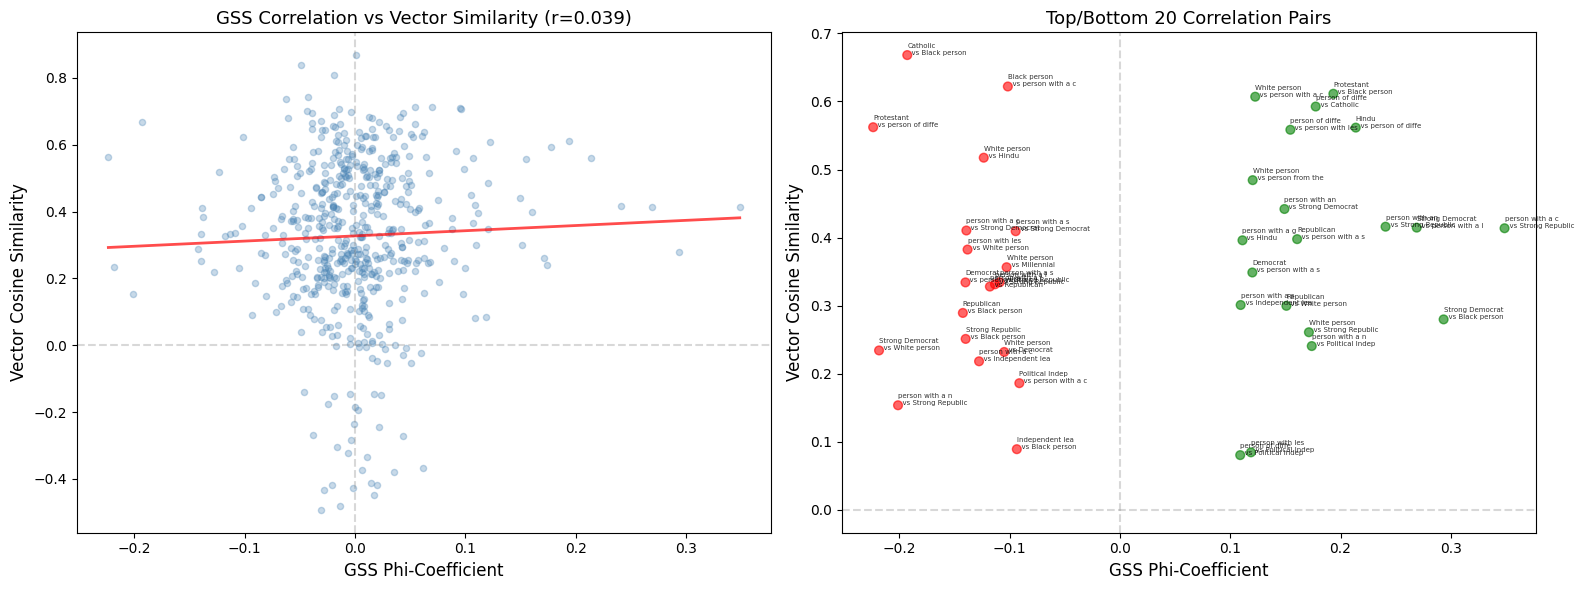


Pearson correlation between phi-coefficient and cosine similarity: 0.0385
Spearman correlation: 0.0462


In [14]:
# Scatter: GSS phi-coefficient vs vector cosine similarity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full scatter
ax = axes[0]
ax.scatter(comp_df['phi_coefficient'], comp_df['cosine_similarity'],
           alpha=0.3, s=20, color='steelblue')

# Fit line
z = np.polyfit(comp_df['phi_coefficient'], comp_df['cosine_similarity'], 1)
p = np.poly1d(z)
x_fit = np.linspace(comp_df['phi_coefficient'].min(), comp_df['phi_coefficient'].max(), 100)
ax.plot(x_fit, p(x_fit), 'r-', linewidth=2, alpha=0.7)

corr = comp_df['phi_coefficient'].corr(comp_df['cosine_similarity'])
ax.set_xlabel('GSS Phi-Coefficient', fontsize=12)
ax.set_ylabel('Vector Cosine Similarity', fontsize=12)
ax.set_title(f'GSS Correlation vs Vector Similarity (r={corr:.3f})', fontsize=13)
ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)

# Highlight extreme pairs
ax2 = axes[1]
top_pairs = comp_df.nlargest(20, 'phi_coefficient')
bottom_pairs = comp_df.nsmallest(20, 'phi_coefficient')
extreme = pd.concat([top_pairs, bottom_pairs])

colors = ['green' if r['phi_coefficient'] > 0 else 'red' for _, r in extreme.iterrows()]
ax2.scatter(extreme['phi_coefficient'], extreme['cosine_similarity'],
            alpha=0.6, s=40, c=colors)

for _, r in extreme.iterrows():
    short1 = r['vec_label1'].split('_', 1)[1][:15]
    short2 = r['vec_label2'].split('_', 1)[1][:15]
    ax2.annotate(f"{short1}\n  vs {short2}",
                 (r['phi_coefficient'], r['cosine_similarity']),
                 fontsize=5, alpha=0.8)

ax2.set_xlabel('GSS Phi-Coefficient', fontsize=12)
ax2.set_ylabel('Vector Cosine Similarity', fontsize=12)
ax2.set_title('Top/Bottom 20 Correlation Pairs', fontsize=13)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPearson correlation between phi-coefficient and cosine similarity: {corr:.4f}")
print(f"Spearman correlation: {comp_df['phi_coefficient'].corr(comp_df['cosine_similarity'], method='spearman'):.4f}")

## Multi-Layer Comparison

Does the demographic PCA structure change across layers? We compare layers 5, 9, 13, 17, 20.

In [15]:
comparison_layers = [5, 9, 13, 17, 20]
layer_results = {}

for layer in comparison_layers:
    vecs = torch.load(
        os.path.join(VECTOR_DIR, f"gss_demographic_vectors_layer{layer}.pt"),
        map_location="cpu",
        weights_only=True,
    )

    layer_labels = sorted(vecs.keys())
    layer_X = np.array([
        (vecs[lab]['vector'] * vecs[lab]['magnitude']).numpy()
        for lab in layer_labels
    ])

    layer_pca = PCA(n_components=min(20, len(layer_labels)))
    layer_X_pca = layer_pca.fit_transform(layer_X)

    layer_results[layer] = {
        'labels': layer_labels,
        'X': layer_X,
        'X_pca': layer_X_pca,
        'pca': layer_pca,
        'explained_variance': layer_pca.explained_variance_ratio_,
    }

    print(f"Layer {layer:2d}: PC1={layer_pca.explained_variance_ratio_[0]:.3f}, "
          f"PC2={layer_pca.explained_variance_ratio_[1]:.3f}, "
          f"PC3={layer_pca.explained_variance_ratio_[2]:.3f}, "
          f"Top-3 cumulative={sum(layer_pca.explained_variance_ratio_[:3]):.3f}, "
          f"n_vectors={len(layer_labels)}")

Layer  5: PC1=0.172, PC2=0.111, PC3=0.086, Top-3 cumulative=0.369, n_vectors=120
Layer  9: PC1=0.165, PC2=0.138, PC3=0.093, Top-3 cumulative=0.396, n_vectors=120
Layer 13: PC1=0.236, PC2=0.136, PC3=0.082, Top-3 cumulative=0.455, n_vectors=120
Layer 17: PC1=0.208, PC2=0.116, PC3=0.095, Top-3 cumulative=0.419, n_vectors=120
Layer 20: PC1=0.218, PC2=0.121, PC3=0.080, Top-3 cumulative=0.419, n_vectors=120


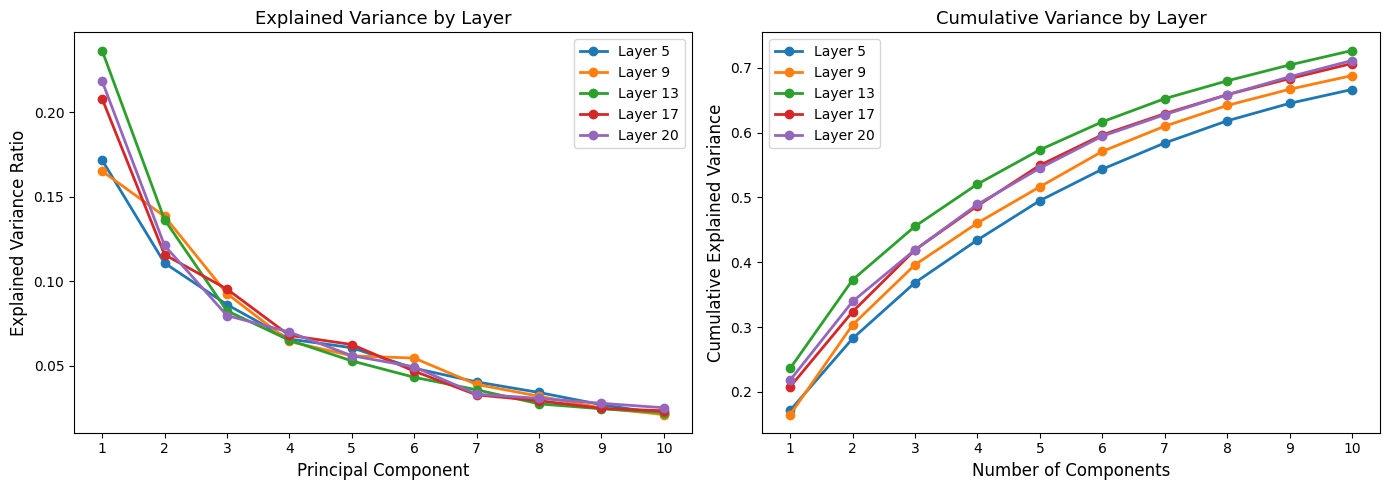

In [16]:
# Plot: explained variance comparison across layers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 explained variance by layer
ax = axes[0]
for layer in comparison_layers:
    ev = layer_results[layer]['explained_variance'][:10]
    ax.plot(range(1, 11), ev, 'o-', label=f'Layer {layer}', linewidth=2, markersize=6)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Explained Variance Ratio', fontsize=12)
ax.set_title('Explained Variance by Layer', fontsize=13)
ax.legend()
ax.set_xticks(range(1, 11))

# Cumulative comparison
ax = axes[1]
for layer in comparison_layers:
    ev = layer_results[layer]['explained_variance'][:10]
    ax.plot(range(1, 11), np.cumsum(ev), 'o-', label=f'Layer {layer}', linewidth=2, markersize=6)
ax.set_xlabel('Number of Components', fontsize=12)
ax.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax.set_title('Cumulative Variance by Layer', fontsize=13)
ax.legend()
ax.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

In [17]:
# Compare PC1 poles across layers: are the same demographics at the extremes?
print("PC1 Poles Across Layers")
print("=" * 80)

for layer in comparison_layers:
    r = layer_results[layer]
    projections = r['X_pca'][:, 0]
    sorted_idx = np.argsort(projections)

    top5 = [r['labels'][i].split('_', 1)[1][:30] for i in sorted_idx[-5:][::-1]]
    bot5 = [r['labels'][i].split('_', 1)[1][:30] for i in sorted_idx[:5]]

    print(f"\nLayer {layer} (PC1 = {r['explained_variance'][0]:.1%}):")
    print(f"  + pole: {', '.join(top5)}")
    print(f"  - pole: {', '.join(bot5)}")

PC1 Poles Across Layers

Layer 5 (PC1 = 17.2%):
  + pole: Republican, Other, Strong Republican, Democrat, Strong Democrat
  - pole: person working in construction, person working in education, l, person working in finance, ins, person working in an office or, person working in management, 

Layer 9 (PC1 = 16.5%):
  + pole: Other, person in fair health, person in good health, person with a bachelor's degre, young adult aged 25 to 39
  - pole: person with an extremely conse, person who does not believe in, person with an extremely liber, person who believes in God but, person who believes in a highe

Layer 13 (PC1 = 23.6%):
  + pole: Other, Independent leaning Democrat, Political Independent, Independent leaning Republican, Democrat
  - pole: person with an extremely conse, person with an extremely liber, person not satisfied with thei, person who believes in God but, person who firmly believes in 

Layer 17 (PC1 = 20.8%):
  + pole: person with an extremely liber, person with an extremel

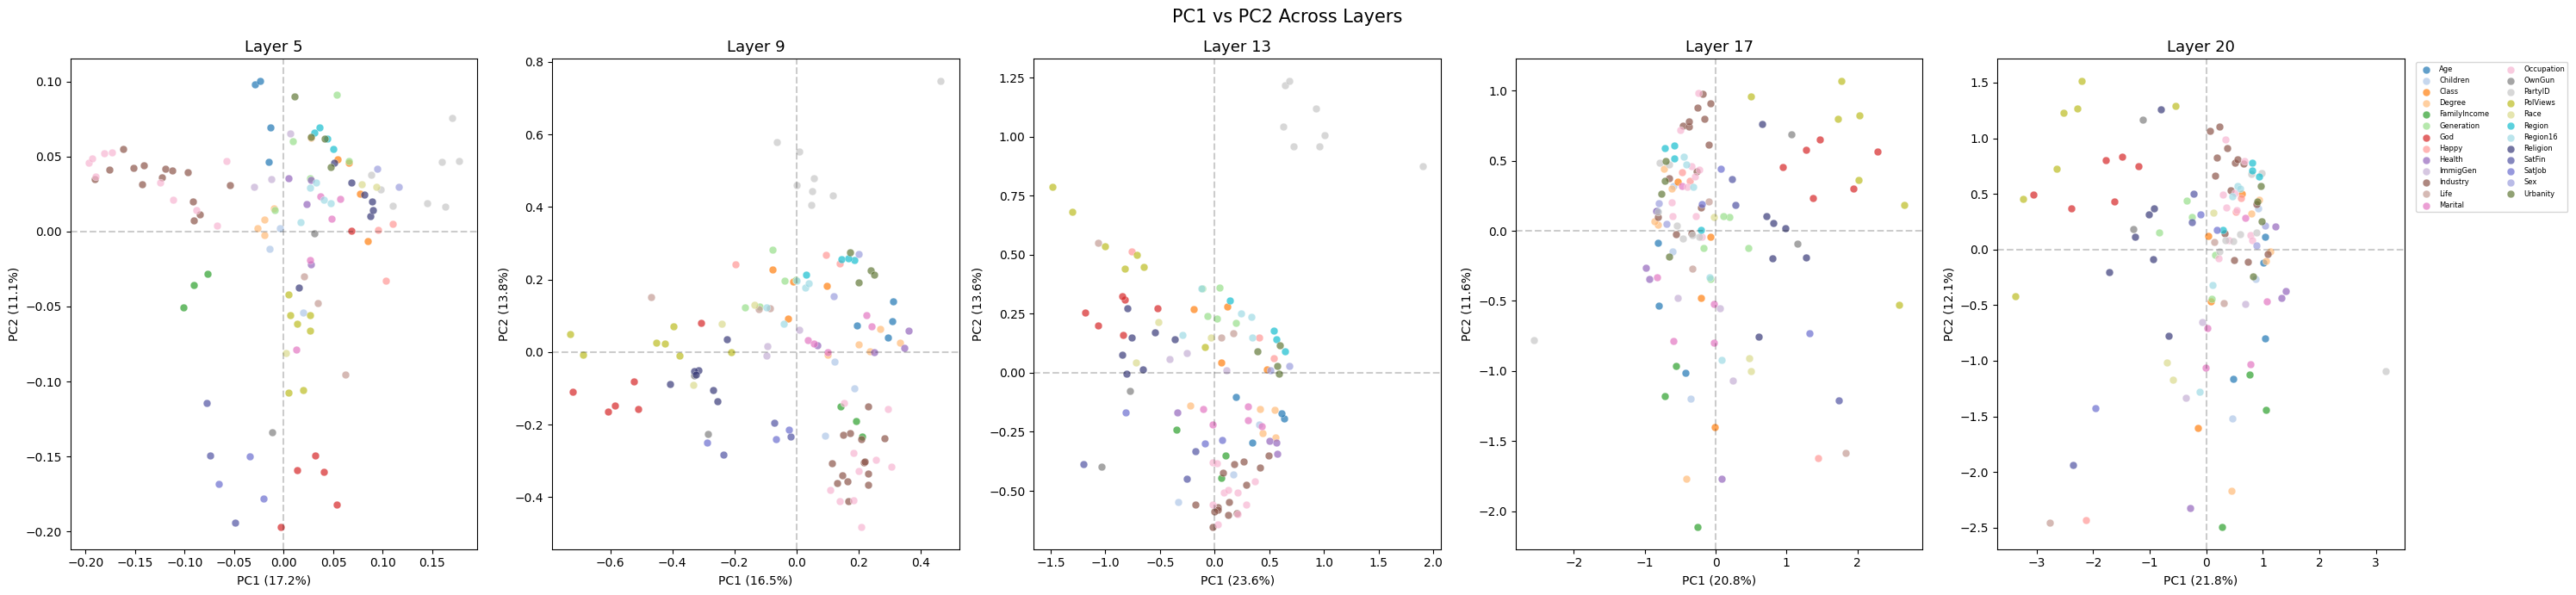

In [18]:
# PC1 vs PC2 scatter across layers
fig, axes = plt.subplots(1, len(comparison_layers), figsize=(6 * len(comparison_layers), 7))

for ax, layer in zip(axes, comparison_layers):
    r = layer_results[layer]
    layer_cats = [lab.split('_')[0] for lab in r['labels']]

    for cat in unique_cats:
        mask = [c == cat for c in layer_cats]
        if any(mask):
            indices = [i for i, m in enumerate(mask) if m]
            ax.scatter(
                r['X_pca'][indices, 0], r['X_pca'][indices, 1],
                label=cat, color=cat_to_color[cat], s=40, alpha=0.7,
                edgecolors='white', linewidth=0.3,
            )

    ax.axhline(0, color='black', linestyle='--', alpha=0.2)
    ax.axvline(0, color='black', linestyle='--', alpha=0.2)
    ax.set_title(f'Layer {layer}', fontsize=13)
    ax.set_xlabel(f"PC1 ({r['explained_variance'][0]:.1%})")
    ax.set_ylabel(f"PC2 ({r['explained_variance'][1]:.1%})")

axes[-1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=6, ncol=2)
plt.suptitle('PC1 vs PC2 Across Layers', fontsize=15)
plt.tight_layout()
plt.show()

## 3D Visualization

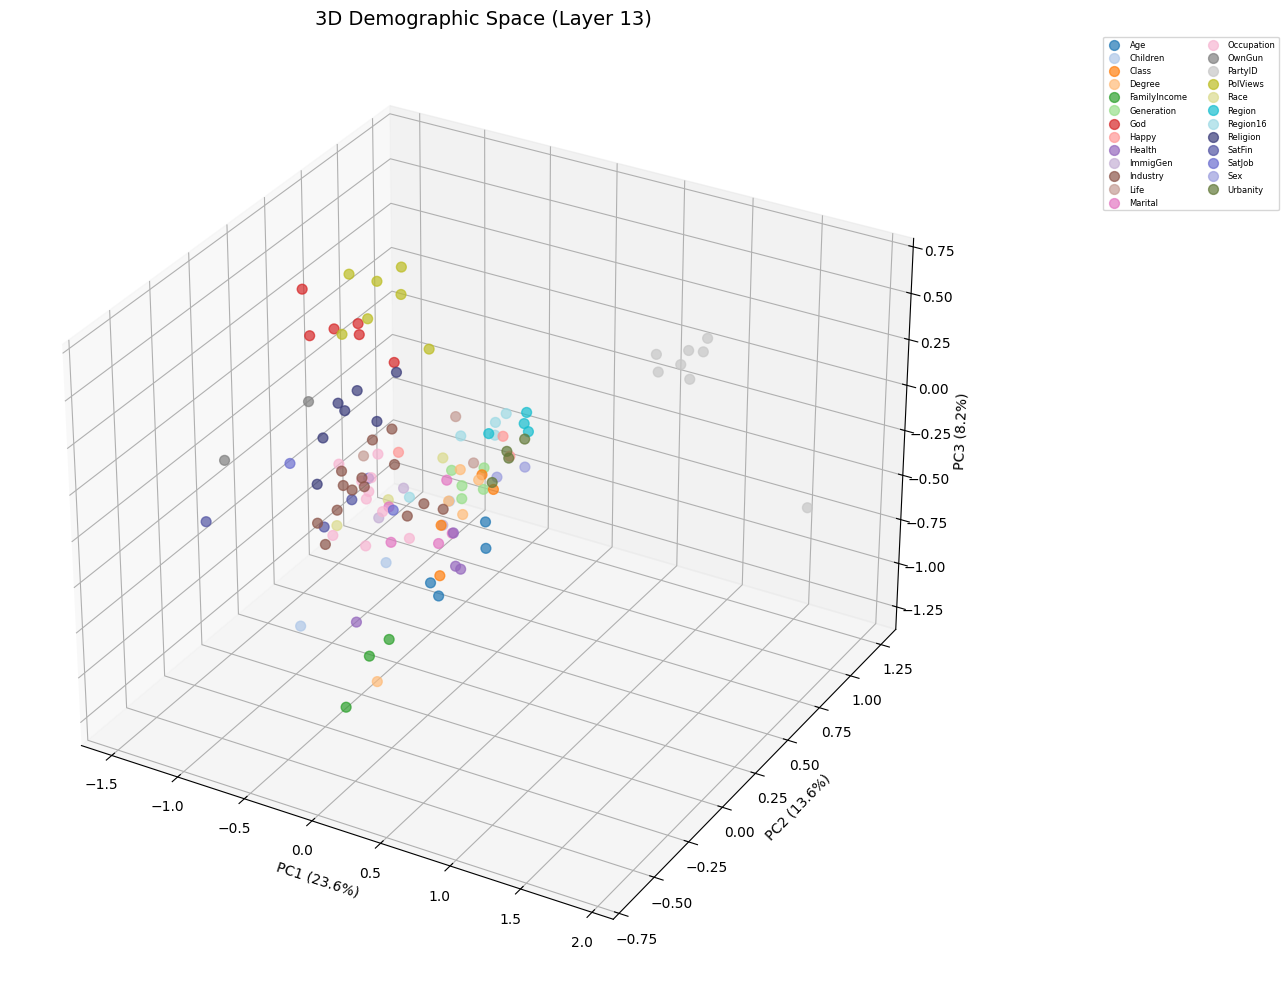

In [19]:
# 3D scatter of PC1/PC2/PC3 using matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for cat in unique_cats:
    mask = df_pca['category'] == cat
    ax.scatter(
        df_pca.loc[mask, 'PC1'],
        df_pca.loc[mask, 'PC2'],
        df_pca.loc[mask, 'PC3'],
        label=cat, color=cat_to_color[cat], s=50, alpha=0.7,
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=10)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=10)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=10)
ax.set_title(f'3D Demographic Space (Layer {REF_LAYER})', fontsize=14)
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=6, ncol=2)

plt.tight_layout()
plt.show()

In [20]:
# Interactive 3D with plotly (if available)
try:
    import plotly.express as px

    fig = px.scatter_3d(
        df_pca, x='PC1', y='PC2', z='PC3',
        color='category', hover_name='label',
        title=f'Interactive 3D Demographic Space (Layer {REF_LAYER})',
        labels={
            'PC1': f"PC1 ({pca.explained_variance_ratio_[0]:.1%})",
            'PC2': f"PC2 ({pca.explained_variance_ratio_[1]:.1%})",
            'PC3': f"PC3 ({pca.explained_variance_ratio_[2]:.1%})",
        },
        width=900, height=700,
    )
    fig.show()
except ImportError:
    print("plotly not available — install with: pip install plotly")

## Summary & Interpretation

### Key Findings

**PC1 — Dominant Axis of Demographic Variation:**
- Hypothesized to be the **Liberal-Conservative** axis
- Check: Does one pole have Republican/Conservative/Gun owner/Religious, and the other have Democrat/Liberal/Non-religious?
- This mirrors the "Assistant Axis" (Lu et al., 2026), where PC1 captured the dominant personality variation

**PC2 — Second Axis:**
- Hypothesized to capture **socioeconomic/education** or **age/generation** variation
- Check: Do education levels, income groups, or age groups separate along this axis?

**PC3 — Third Axis:**
- May capture **urban/rural** or **occupation specificity** variation

### GSS Validation
- Positive Pearson/Spearman correlation between GSS phi-coefficients and vector cosine similarity would confirm that the model's internal demographic geometry reflects real-world statistical associations

### Multi-Layer Structure
- The PC structure should emerge most clearly in middle-to-late layers (9-17), where the model adds the most demographic-specific information
- Early layers (5) may show less structured variation

### Next Steps
- **Phase 6**: Use LLM judge filtering to clean vector estimates
- **Phase 7**: Track demographic drift in multi-turn conversations on politically charged topics
- **Phase 8**: Apply activation capping along the dominant demographic axes